## 数据挖掘-2023 互评作业二：网页浏览行为关联规则挖掘

[仓库地址](https://github.com/lyl2000/data-mining)

### 数据预处理: 清洗数据，处理缺失值，提取用户浏览记录

In [1]:
def read_data(path):
    with open(path, 'r') as f:
        data = f.read()
    data = data.split('\n')
    web = {}
    user = {}
    cur = None
    webs = []
    for i, e in enumerate(data[:-1]):
        if e[0] == 'A':  # Attribute lines
            r = e.split(',')
            web[r[1]] = [r[3], r[4]]
        elif e[0] == 'C':
            r = e.split(',')
            cur = r[-1]
            user[cur] = []
        elif e[0] == 'V':
            r = e.split(',')
            user[cur].append(r[1])
            webs.append(r[1])
    return web, user, webs

train_web, train_user, train_webs = read_data('anonymous-msweb.data')
test_web, test_user, test_webs = read_data('anonymous-msweb.test')

In [2]:
len(train_user), len(train_web), len(test_user), len(test_web), len(train_webs), len(test_webs)

(32711, 294, 5000, 294, 98654, 15191)

### 数据探索性分析: 分析最常被访问的页面、页面访问量分布等

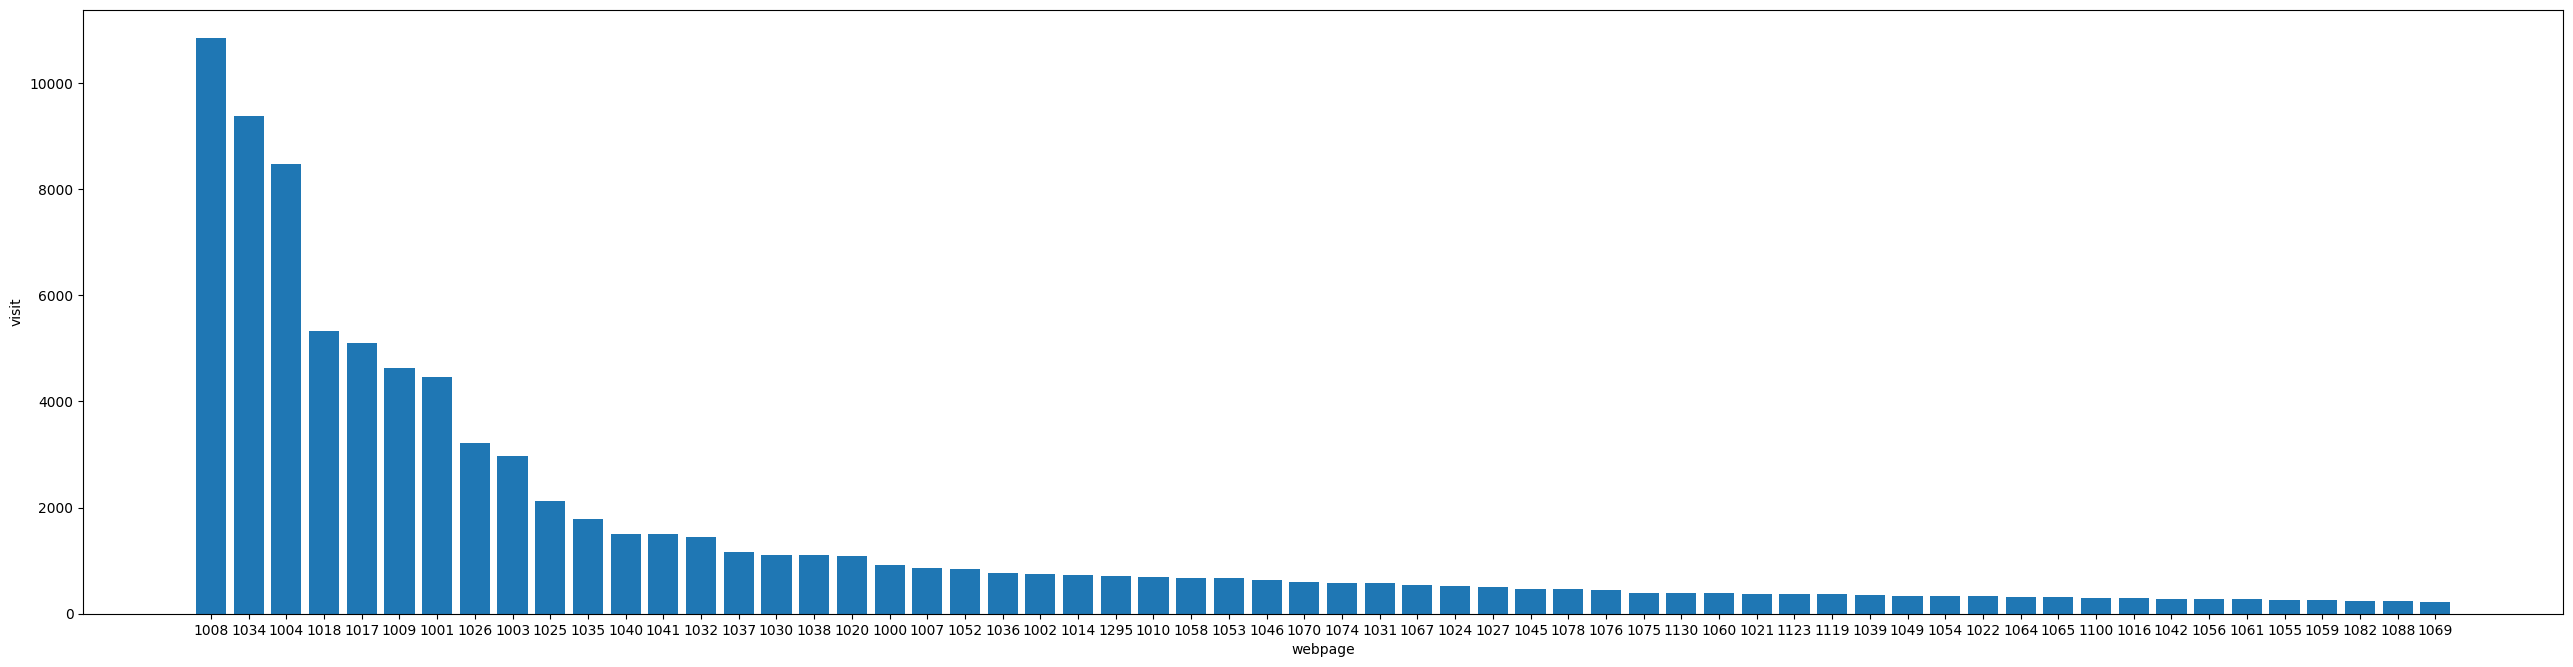

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

plt.figure(dpi=100, figsize=(32, 8))
cnt = sorted(dict(Counter(train_webs)).items(), key=lambda x:x[1], reverse=True)
k, v = [e[0] for e in cnt], [e[1] for e in cnt]
n = 60
plt.bar(k[:n], v[:n], width=0.8)
plt.xlabel('webpage')
plt.ylabel('visit')
plt.show()

最常被访问的网页是1008，之后是1034，1004...

### 关联规则挖掘: 使用Apriori算法或FP-growth算法，根据用户浏览记录计算频繁项集和关联规则

In [27]:
def apriori(data):

    min_sup = 0.07
    # 生成单元数候选项集
    c_1 = []
    for v in data:
        for e in v:
            if [e] not in c_1:
                c_1.append([e])
    c_1 = [frozenset(e) for e in c_1]
    print(c_1)
    data = [set(v) for v in data]

    def filter_low(ck):
        cnt = {}
        for v in data:
            for cand in ck:
                if cand.issubset(v):
                    if cand not in cnt:
                        cnt[cand] = 1
                    else:
                        cnt[cand] += 1
        ret_f = [k for k in cnt.keys() if cnt[k] / len(data) >= min_sup]
        ret_sup = {k: v / len(data) for k, v in cnt.items()}
        return ret_f, ret_sup
    
    f_1, sup = filter_low(c_1)
    print(f_1)
    
    f = [f_1]
    k = 2
    while len(f[k-2]) > 0:
        c_k = gene_apriori(f[k-2], k)
        print('c_k: ', c_k)
        f_k, sup_k = filter_low(c_k)
        sup.update(sup_k)
        f.append(f_k)
        k += 1
    return f, sup

def gene_apriori(fk, k):
    ret = []
    for i in range(len(fk)):
        for j in range(i+1, len(fk)):
            f1 = list(fk[i])[:k-2]
            f2 = list(fk[j])[:k-2]
            f1.sort()
            f2.sort()
            # 前 k-2 项相同时合并
            if f1 == f2:
                ret.append(fk[i] | fk[j])
    return ret

def gene_rules(f, sup):
    ret = []
    min_conf = 0.5

    def reasoned_item(freq_set, h):
        m = len(h[0])
        if len(freq_set) > m + 1:
            hmpl = gene_apriori(h, m+1)
            hmpl = calc_conf(freq_set, hmpl)
            if len(hmpl) > 1:
                reasoned_item(freq_set, hmpl)

    def calc_conf(freq_set, h):
        new_h = []
        for e in h:
            conf = sup[freq_set] / sup[freq_set - e]
            lift = conf / sup[e]
            jaccard = sup[freq_set] / (sup[freq_set - e] + sup[e] - sup[freq_set])
            if conf >= min_conf:
                ret.append(((list(freq_set - e), list(e)), sup[freq_set], conf, lift, jaccard))
                new_h.append(e)
        return new_h

    for i in range(1, len(f)):
        for freq_set in f[i]:
            h = [frozenset([e]) for e in freq_set]
            if i > 1:
                reasoned_item(freq_set, h)
            else:
                calc_conf(freq_set, h)
    return ret


freq_sets, sup_data = apriori(train_user.values())

strong_rules = gene_rules(freq_sets, sup_data)

[frozenset({'1000'}), frozenset({'1001'}), frozenset({'1002'}), frozenset({'1003'}), frozenset({'1004'}), frozenset({'1005'}), frozenset({'1006'}), frozenset({'1007'}), frozenset({'1008'}), frozenset({'1009'}), frozenset({'1010'}), frozenset({'1011'}), frozenset({'1012'}), frozenset({'1013'}), frozenset({'1014'}), frozenset({'1015'}), frozenset({'1016'}), frozenset({'1017'}), frozenset({'1018'}), frozenset({'1019'}), frozenset({'1020'}), frozenset({'1021'}), frozenset({'1022'}), frozenset({'1023'}), frozenset({'1024'}), frozenset({'1025'}), frozenset({'1026'}), frozenset({'1027'}), frozenset({'1028'}), frozenset({'1029'}), frozenset({'1030'}), frozenset({'1031'}), frozenset({'1032'}), frozenset({'1033'}), frozenset({'1034'}), frozenset({'1035'}), frozenset({'1036'}), frozenset({'1037'}), frozenset({'1038'}), frozenset({'1039'}), frozenset({'1040'}), frozenset({'1041'}), frozenset({'1042'}), frozenset({'1043'}), frozenset({'1044'}), frozenset({'1045'}), frozenset({'1046'}), frozenset({'

In [25]:
for v in freq_sets:
    for e in v:
        print(list(e), sup_data[e])

['1001'] 0.1360704350218581
['1003'] 0.09073400385191525
['1004'] 0.2587203081532206
['1008'] 0.33126471217633213
['1009'] 0.14148145883647703
['1017'] 0.1561554217235792
['1018'] 0.162942129558864
['1026'] 0.09843783436764392
['1034'] 0.2868454036868332
['1009', '1008'] 0.07792485708171563
['1018', '1008'] 0.07306410687536302
['1034', '1008'] 0.16080217663782825


### 结果评估: 计算关联规则的支持度、置信度和提升度，得出强关联规则。

In [31]:
for e in strong_rules:
    print('{}: 支持度 {}，置信度 {}，提升度 {}'.format(e[0], e[1], e[2], e[3]))

(['1009'], ['1008']): 支持度 0.07792485708171563，置信度 0.5507778738115817，提升度 1.6626518115772102
(['1034'], ['1008']): 支持度 0.16080217663782825，置信度 0.5605882979857189，提升度 1.6922668711158038


### 结果分析与应用: 分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。

由结果知 网站1009和1008，1034和1008有较强联系